# Zillow Project - Predict Zestimate (logerror)

#### Goals:

1. Build a model to predict Zestimate (logerror)

2. I.D. what is driving the Zestimate

### Planning
Pipeline:
    
   1. ***Acquire*** - Create a sql query that will connect to zillow database. The query will pull data for properties that were sold in 2017, and their Zestimate. The dataframe aquired will give us features to evaluate how they effect the Zestimate target variable.
   2. ***Prep*** - Clean NaN values with imputing, and setting qualifying properties for columns and rows with proportions that must be filled. Rename columns to be short and easy to use names. Put features in to proper numeric and catagorical data types. Scale features to be used in explore
   3. ***Explore*** - Split prepped dataframe into train and test. Use clustering to find out how different properties, are distributed in the zestimate target. Use statistical tests to find how properties in the dataset are simalar or different. Create new features from dataset, that can give more insight into what influences the value of properites. Find top features that drive Zestimate to create predictive Model
   4. ***Model*** - Create predictive models with features evaluated in explore phase. Evaluate models to find closest predictive error to the actual Zestimate.

### Acquire

***sql query***: We created a query that uses the zillow dataset to select properties that were sold in 2017. If a house was sold multiple times in 2017 we only selected the most recent transaction date. The properties_2017 table contained all of the features of homes such as sqft, value, location, etc.

In this notebook we will read the dataframe produced by the query from a csv file. If needed included in this project repository is the [acquire file](https://github.com/callapena/zillow_cluster/blob/master/acquire.py) used to query from mysql (will need personal env.py file).

In [1]:
# make imports for modules and packages to be used throughout the notebook.
import warnings
warnings.filterwarnings("ignore")

import acquire
import prepare
from split_scale import scale

import pandas as pd 
import numpy as np 

import seaborn as sns
sns.set_style('whitegrid')
sns.set_palette('husl')
import matplotlib.pyplot as plt 
from matplotlib import cm

from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

from scipy import stats

from mpl_toolkits.mplot3d import Axes3D


In [ ]:
#import ipympl

In [2]:
# read dataframe from zillow.csv file.
zillow = acquire.get_zillow()

### Prepare.py

In [3]:
# Initial view of dataframe using.info()
# rows: 52292
# columns: 62
zillow.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52292 entries, 0 to 52291
Data columns (total 62 columns):
Unnamed: 0                      52292 non-null int64
logerror                        52292 non-null float64
transactiondate                 52292 non-null object
id                              52292 non-null int64
parcelid                        52292 non-null int64
airconditioningtypeid           13610 non-null float64
architecturalstyletypeid        70 non-null float64
basementsqft                    47 non-null float64
bathroomcnt                     52292 non-null float64
bedroomcnt                      52292 non-null float64
buildingclasstypeid             0 non-null float64
buildingqualitytypeid           33632 non-null float64
calculatedbathnbr               52158 non-null float64
decktypeid                      388 non-null float64
finishedfloor1squarefeet        4368 non-null float64
calculatedfinishedsquarefeet    52211 non-null float64
finishedsquarefeet12           

***Prepare steps:***
1. Drop columns that have less than 10% non-null value, then rows that have less than 60% non-null values
2. Drop columns that appear to provide little information:
    - `assessmentyear`
    - `unitcnt` (all 1)
    - `finishedsquarefeet12`
    - `propertylandusetypeid`
    - `rawcensustractandblock`
    - `censustractandblock`
    - `threequarterbathnbr`
    - `pooltypeid7`
    - `roomcnt`
    - `buildingqualitytypeid`
    - `calculatedbathnbr`
3. Drop rows that have 0/null beds, baths, or sqft
4. Dictionary for shorter names
5. Drop outliers - 
    - sqft > 10,000 
    - lotsizesqft > 3,000
    - structurevalue > 1,000,000 or < 0
    - beds > 7
    - bath > 7
    - garage > 5
    - stories > 3
6. Columns that will be dropped based off of non-null and information gain value:
    - `airconditioningtypeid` - Few values in column, 75% missing.
    - `fullbathcnt` - Already have similar information in bathcnt that has no non-null values. Will drop because of redundancy.
    - `heatingorsystemtypeid` - This will not be a major driver of logerror. Might be added in a later follow up and impute values.
    - `propertylandusecodetypeid` - All of these values are single family residential `id: 261`
    - `propertycountylandusecode` - Zoning at the county level. Little information gainded from this column.
    - `propertyzoningdesc` -Description of the allowed land use(zoning) for that property. Not sure what information is gained from this feature to drive zestimate error.
    - `regionidcounty` - Three county values, and same value counts as fips. Will drop because of redundancy.
    - `regionidneighborood` - Don't know where these neighborhoods are. Might use in later research if able to plot applicable neighborhoods.
    - `regionidzip` - Similar to neighborhood. Not sure where these zips correspond to.
    - `number of stories` - Few values in column, 72% missing.
7. Imputations - There was a roughly linear correlation between landvalue and lotsize.
8. Nulls represent 'no' or 0 - fireplace, pool

In [4]:
# Run prep_zillow from prepare module.
# prepped data frame info
# rows: 48944
# columns: 18
zillow = prepare.prep_zillow(zillow)
zillow.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48879 entries, 0 to 52290
Data columns (total 21 columns):
Unnamed: 0          48879 non-null int64
logerror            48879 non-null float64
date                48879 non-null object
baths               48879 non-null float64
beds                48879 non-null float64
sqft                48879 non-null float64
fips                48879 non-null float64
fireplace           48879 non-null int64
lat                 48879 non-null float64
long                48879 non-null float64
lotsqft             48879 non-null float64
pool                48879 non-null float64
city                48879 non-null float64
strucvalue          48879 non-null float64
value               48879 non-null float64
landvalue           48879 non-null float64
tax                 48879 non-null float64
age                 48879 non-null float64
strucvaluebysqft    48879 non-null float64
landvaluebysqft     48879 non-null float64
beds_and_baths      48879 non-null f

***Data dictionary:***

- ***logerror*** - logerror value of Zillow property value estimation ("zestimate"). This value was given in the data, and not aware of how zillow got these log values (i.e. base value used and transformations).
- ***date*** - transaction date the property was sold.
- ***baths*** - number of baths on the property including factional baths.
- ***beds*** - number of beds on the property.
- ***sqft*** - total finished living area of the home.
- ***fips*** -  Federal Information Processing Standard code -  see [wikipedia page - Fips county code](https://en.wikipedia.org/wiki/FIPS_county_code) for more details
- ***fireplace*** - Is there a fireplace in this property.
- ***lat*** - latitude of the middle of the parcel multiplied by 10e6.
- ***long*** - longitude of the middle of the parcel multiplied by 10e6.
- ***lotsqft*** - Area of the lot in square feet.
- ***pool*** - Is there apool in this property.
- ***city*** - In which city is the property located.
- ***strucvalue*** - The assessed value of the built structure on the parcel.
- ***value*** - The total tax assesed value of the property.
- ***landvalue*** - the assvalue of the land area of the property.
- ***tax*** - The total property tax for the assessment year.
- ***age*** - age of the house from 2017.

### Explore

Explore distributions of variables in the dataset, and how they drive target logerror variable.

In [6]:
# ENCODE FIPS AND CITY
# actually not sure how to do that with city... there are many different values. might have to map them or something?
# 6037 is LA, 6059 is Orange, 6111 is Ventura
zillow['la'] = (zillow['fips'] == 6037).astype(int)
zillow['orange'] = (zillow['fips'] == 6059).astype(int)
zillow['ventura'] = (zillow['fips'] == 6111).astype(int)


In [7]:
train, test = train_test_split(zillow, test_size=.30, random_state=123)
X1_train = train[['sqft', 'lotsqft', 'tax', 'age']]
y1_train = train['logerror']
test1 = test[['sqft', 'lotsqft', 'tax', 'age', 'logerror']]


features = ['beds_and_baths', 'sqft', 'fireplace', 'lat', 'long', 'lotsqft', 'pool',
            'tax', 'age', 'strucvaluebysqft', 'landvaluebysqft', 'la', 'orange', 'ventura']
target = 'logerror'

# SCALE
uniform = ['beds_and_baths', 'sqft', 'lotsqft', 'strucvaluebysqft', 'landvaluebysqft', 'tax']
minmax = ['lat', 'long', 'age']
uniform_scaler, train, test = scale(train, test, uniform, scaler='uniform')
minmax_scaler, train, test = scale(train, test, minmax, scaler='minmax')

X_train = train[features]
X_test = test[features]
y_train = train[target]
y_test = test[target]

In [ ]:
# # Create train & test
# train, test = train_test_split(zillow, test_size=.30, random_state=123)

# # SCALE
# minmax = ['lat', 'long', 'age', 'logerror','sqft','lotsqft', 'tax']
# minmax_scaler, train_scaled, test_scaled = scale(train[minmax], test[minmax], minmax, scaler='minmax')

In [8]:
train.describe().T

count           mean            std        min  \
Unnamed: 0        34215.0   26029.401929   15123.641878     0.0000   
logerror          34215.0       0.017814       0.167405    -2.3878   
baths             34215.0       2.225121       0.897592     1.0000   
beds              34215.0       3.268479       0.889521     1.0000   
fips              34215.0    6049.120240      20.837723  6037.0000   
fireplace         34215.0       0.139354       0.346321     0.0000   
pool              34215.0       0.197107       0.397819     0.0000   
city              34215.0   33953.016864   50386.186150  3491.0000   
strucvalue        34215.0  169174.424901  145057.483782   181.0000   
value             34215.0  463732.005699  436690.845889  9242.0000   
landvalue         34215.0  294557.580798  339078.884808  2250.0000   
la                34215.0       0.642233       0.479350     0.0000   
orange            34215.0       0.276049       0.447048     0.0000   
ventura           34215.0       0.081719       0.273939     0.0000   
beds_and_baths    34215.0       0.500008       0.284391     0.0000   
sqft              34215.0       0.499989       0.288694     0.0000   
lotsqft           34215.0       0.500001       0.288686     0.0000   
strucvaluebysqft  34215.0       0.500001       0.288686     0.0000   
landvaluebysqft   34215.0       0.499999       0.288686     0.0000   
tax               34215.0       0.499999       0.288689     0.0000   
lat               34215.0       0.485423       0.194196     0.0000   
long              34215.0       0.671722       0.187695     0.0000   
age               34215.0       0.387746       0.164113     0.0000   

                            25%            50%            75%           max  
Unnamed: 0         12952.000000   25940.000000   39140.500000  5.228900e+04  
logerror              -0.024180       0.006837       0.039203  3.175688e+00  
baths                  2.000000       2.000000       3.000000  7.000000e+00  
beds                   3.000000       3.000000       4.000000  7.000000e+00  
fips                6037.000000    6037.000000    6059.000000  6.111000e+03  
fireplace              0.000000       0.000000       0.000000  1.000000e+00  
pool                   0.000000       0.000000       0.000000  1.000000e+00  
city               12447.000000   24812.000000   40227.000000  3.965560e+05  
strucvalue         75011.500000  126906.000000  212000.000000  1.000000e+06  
value             187984.500000  364079.000000  588876.000000  1.087391e+07  
landvalue          72587.500000  212801.000000  393745.500000  1.054104e+07  
la                     0.000000       1.000000       1.000000  1.000000e+00  
orange                 0.000000       0.000000       1.000000  1.000000e+00  
ventura                0.000000       0.000000       0.000000  1.000000e+00  
beds_and_baths         0.246747       0.390891       0.758759  1.000000e+00  
sqft                   0.250250       0.500501       0.750083  1.000000e+00  
lotsqft                0.250000       0.500100       0.749955  1.000000e+00  
strucvaluebysqft       0.250038       0.499926       0.749916  1.000000e+00  
landvaluebysqft        0.250010       0.500053       0.749958  1.000000e+00  
tax                    0.250001       0.500077       0.750072  1.000000e+00  
lat                    0.347944       0.482866       0.605976  1.000000e+00  
long                   0.564344       0.694033       0.810662  1.000000e+00  
age                    0.282609       0.405797       0.478261  1.000000e+00

In [9]:
# Create correlation table to look at variables as they relate to logerror.
train.corr()

Unnamed: 0  logerror     baths      beds      fips  \
Unnamed: 0          1.000000  0.002511  0.019662  0.015311  0.010286   
logerror            0.002511  1.000000  0.028335  0.030930  0.004341   
baths               0.019662  0.028335  1.000000  0.624530  0.133619   
beds                0.015311  0.030930  0.624530  1.000000  0.151796   
fips                0.010286  0.004341  0.133619  0.151796  1.000000   
fireplace           0.019003 -0.006930  0.108986  0.138226  0.661703   
pool                0.019848 -0.015526  0.274966  0.228159  0.012711   
city               -0.014181  0.009333 -0.051964 -0.044116 -0.047791   
strucvalue          0.016940 -0.001322  0.685208  0.410771  0.132604   
value               0.012649 -0.020094  0.484656  0.239597  0.061957   
landvalue           0.009043 -0.025313  0.331044  0.132843  0.023066   
la                 -0.001427 -0.019826 -0.185980 -0.173187 -0.779316   
orange             -0.007042  0.026361  0.164014  0.128200  0.292779   
ventura             0.013990 -0.008327  0.057777  0.093838  0.885885   
beds_and_baths      0.020721  0.030597  0.857062  0.881946  0.177388   
sqft                0.021970  0.021041  0.797265  0.651740  0.161089   
lotsqft             0.008301  0.005594  0.280012  0.277836  0.008227   
strucvaluebysqft    0.023912 -0.038292  0.342422  0.133202  0.135661   
landvaluebysqft     0.011795 -0.026860  0.174605  0.011384  0.079219   
tax                -0.022597  0.009225 -0.225080 -0.114190 -0.400696   
lat                 0.004280 -0.020930 -0.029111  0.010996 -0.070376   
long               -0.019081  0.027851  0.033608  0.011791 -0.363272   
age                -0.015299 -0.012158 -0.535346 -0.376018 -0.317284   

                  fireplace      pool      city  strucvalue     value  ...  \
Unnamed: 0         0.019003  0.019848 -0.014181    0.016940  0.012649  ...   
logerror          -0.006930 -0.015526  0.009333   -0.001322 -0.020094  ...   
baths              0.108986  0.274966 -0.051964    0.685208  0.484656  ...   
beds               0.138226  0.228159 -0.044116    0.410771  0.239597  ...   
fips               0.661703  0.012711 -0.047791    0.132604  0.061957  ...   
fireplace          1.000000  0.066867 -0.028408    0.060720  0.043621  ...   
pool               0.066867  1.000000 -0.026111    0.263068  0.199376  ...   
city              -0.028408 -0.026111  1.000000   -0.033711 -0.014334  ...   
strucvalue         0.060720  0.263068 -0.033711    1.000000  0.763799  ...   
value              0.043621  0.199376 -0.014334    0.763799  1.000000  ...   
landvalue          0.030203  0.144231 -0.004039    0.555878  0.961122  ...   
la                -0.539130 -0.038198  0.067119   -0.125702 -0.118031  ...   
orange             0.229523  0.046892 -0.059578    0.072946  0.124567  ...   
ventura            0.568828 -0.009685 -0.020221    0.100917  0.003252  ...   
beds_and_baths     0.157973  0.273174 -0.058068    0.560452  0.363892  ...   
sqft               0.166963  0.309407 -0.054717    0.653278  0.461221  ...   
lotsqft            0.046585  0.330460 -0.027193    0.234459  0.145991  ...   
strucvaluebysqft   0.046329  0.142293 -0.019414    0.725057  0.578069  ...   
landvaluebysqft    0.057762  0.009241  0.013746    0.389115  0.658219  ...   
tax               -0.332848 -0.128068 -0.051196   -0.337485 -0.460513  ...   
lat               -0.069761  0.010886 -0.011678   -0.043832 -0.186125  ...   
long              -0.214670  0.002303  0.002052   -0.032910  0.002066  ...   
age               -0.205463 -0.091304  0.075748   -0.447529 -0.198232  ...   

                   ventura  beds_and_baths      sqft   lotsqft  \
Unnamed: 0        0.013990        0.020721  0.021970  0.008301   
logerror         -0.008327        0.030597  0.021041  0.005594   
baths             0.057777        0.857062  0.797265  0.280012   
beds              0.093838        0.881946  0.651740  0.277836   
fips              0.885885        0.177388  0.161089  0.008227   
fireplace         0.

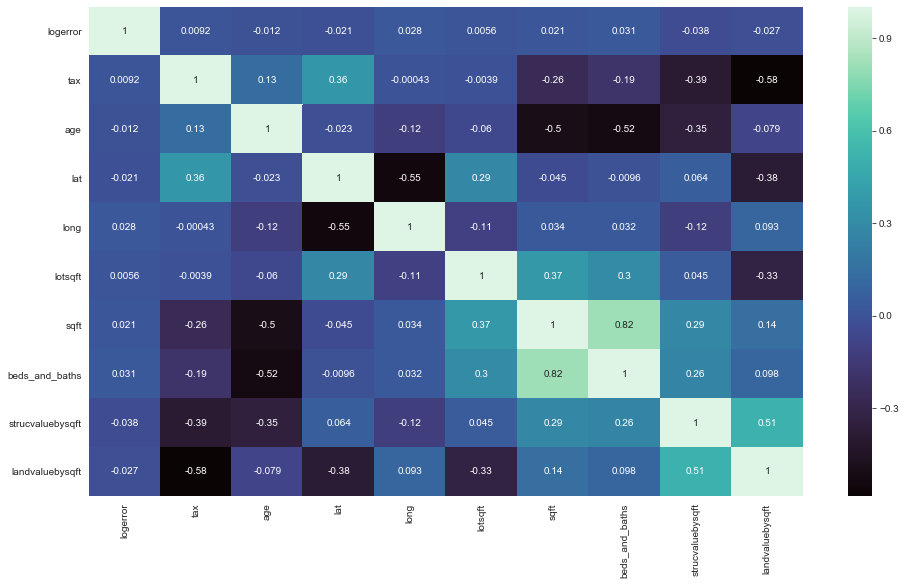

In [11]:
# Create correlation table to look at variables as they relate to logerror.
train_scaled_vars = train[['logerror', 'tax', 'age', 'lat','long','lotsqft','sqft','beds_and_baths','strucvaluebysqft', 'landvaluebysqft']]
plt.figure(figsize = (16,9))
g = sns.heatmap(train_scaled_vars.corr(), annot=True, cmap = "mako")

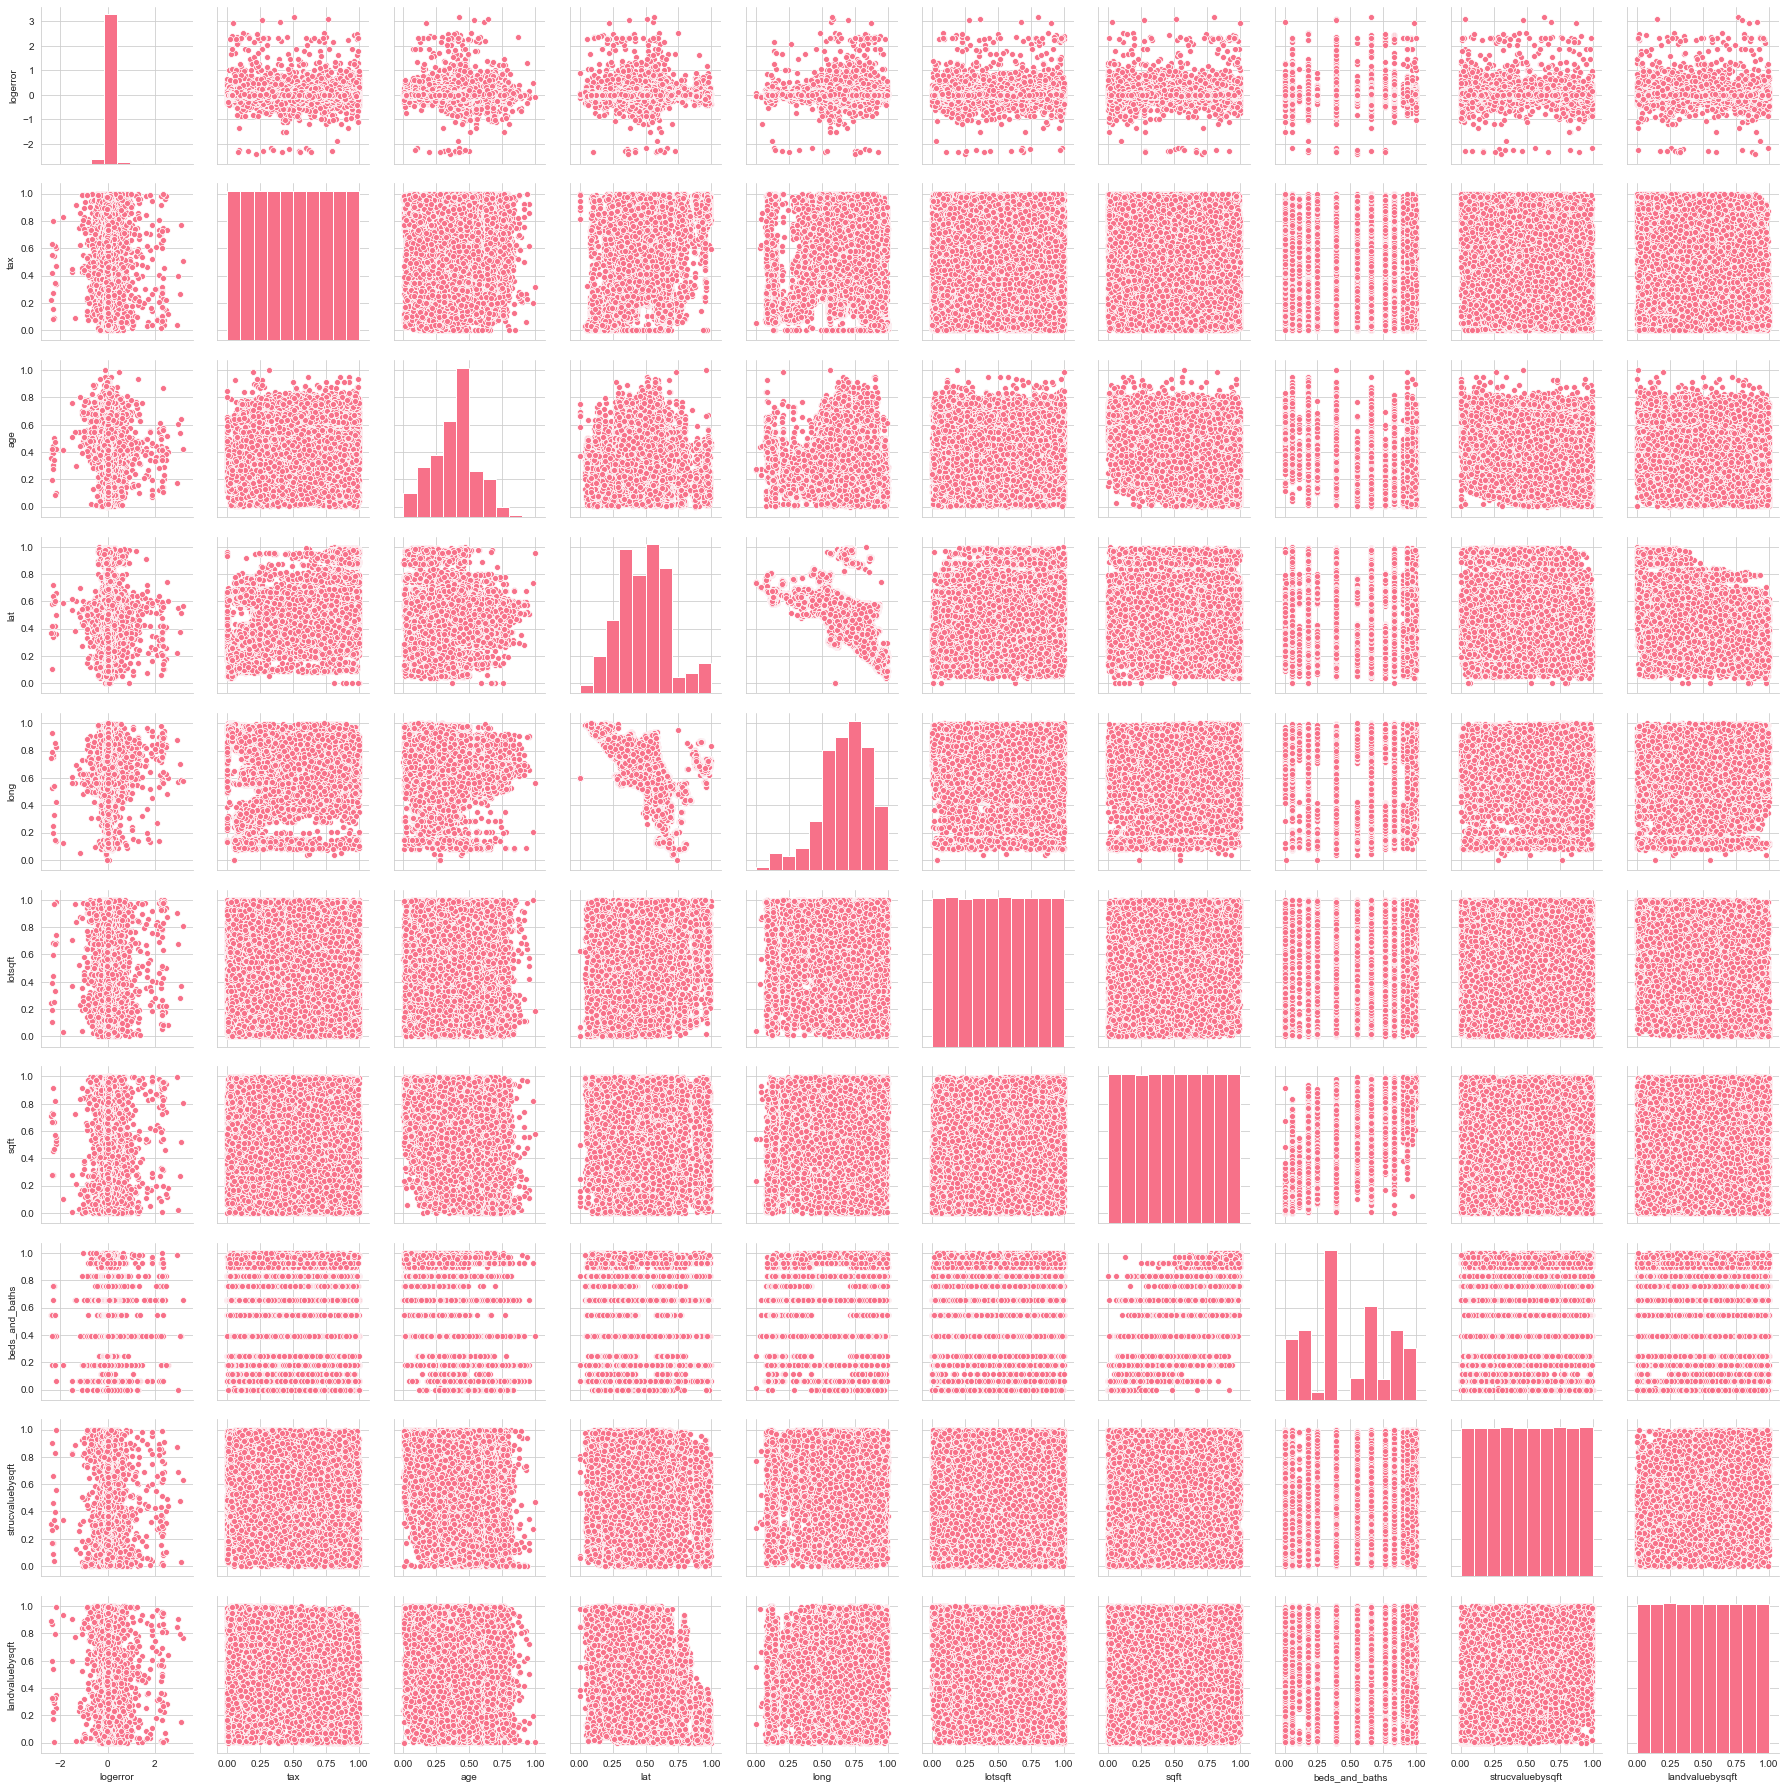

In [12]:
sns.pairplot(train_scaled_vars)

### Exploring: Clustering on logerror

In [13]:
train.logerror.value_counts(bins = 4).sort_index()

(-2.3939999999999997, -0.997]       32
(-0.997, 0.394]                  33624
(0.394, 1.785]                     501
(1.785, 3.176]                      58
Name: logerror, dtype: int64

In [14]:
train.logerror.value_counts(bins=4).sort_index()

(-2.3939999999999997, -0.997]       32
(-0.997, 0.394]                  33624
(0.394, 1.785]                     501
(1.785, 3.176]                      58
Name: logerror, dtype: int64

(-0.5, 0.5)

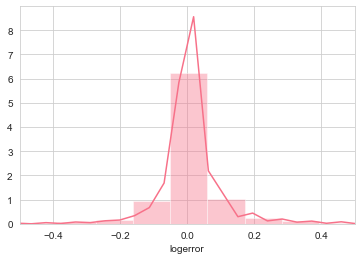

In [15]:
sns.distplot(train.logerror)
plt.xlim(-.5,.5)


     k         sse
0    1  958.829296
1    2  572.397507
2    3  398.570651
3    4  271.484940
4    5  203.788375
5    6  147.584199
6    7  110.185254
7    8   84.298783
8    9   66.345141
9   10   53.611858
10  11   44.614033
11  12   37.353441


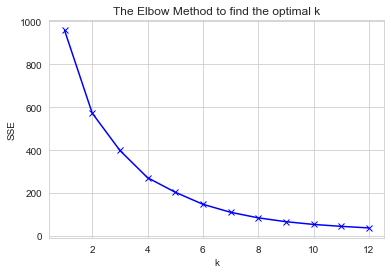

In [16]:
ks = range(1,13)
sse = []
for k in ks:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(train[['logerror']])

    # inertia: Sum of squared distanes of samplesto their closest cluster
    sse.append(kmeans.inertia_)
print(pd.DataFrame(dict(k=ks, sse=sse)))

plt.plot(ks, sse, 'bx-')
plt.xlabel('k')
plt.ylabel('SSE')
plt.title('The Elbow Method to find the optimal k')
plt.show()

In [17]:
kmeans = KMeans(n_clusters = 8, random_state = 123)
kmeans.fit(train[['logerror']])

train['log_cluster'] = kmeans.predict(train[['logerror']])
train.log_cluster = 'cluster_' + train.log_cluster.astype('str')

In [18]:
train.log_cluster.value_counts()

cluster_1    22108
cluster_0     6832
cluster_6     3421
cluster_4     1259
cluster_2      280
cluster_5      226
cluster_3       69
cluster_7       20
Name: log_cluster, dtype: int64

***Insight*** When using KMeans to cluster properties by logerror we see that %66 of the properties are put into one cluster. When there is a very large cluster that contains most of the data we can day that the logerrors between the properties are very similar.

In [19]:
pd.DataFrame(kmeans.cluster_centers_, columns=zillow[['logerror']].columns)\
    .reset_index()\
    .rename({'index': 'cluster'}, axis=1)\
    .set_index('cluster')

logerror
cluster          
0        0.083584
1       -0.003067
2       -0.545643
3        2.182844
4        0.313222
5        0.844250
6       -0.125408
7       -2.083002

In [20]:
train.logerror.mean()

0.017814098096996096

In [21]:
train[train.log_cluster == 'cluster_1'].logerror.mean()

-0.0031837800993108137

In [22]:
train[train.log_cluster != 'cluster_1'].logerror.mean()

0.05615729551699722

In [23]:
train.log_cluster.unique()

array(['cluster_5', 'cluster_0', 'cluster_3', 'cluster_1', 'cluster_4',
       'cluster_6', 'cluster_2', 'cluster_7'], dtype=object)

In [24]:
significant_clusters = []
p_vals = []

for i in train.log_cluster.unique():
    stat, pval = stats.ttest_ind(
        train[train.log_cluster == i].logerror,
        train[train.log_cluster != i].logerror)
    if pval < .05:
        significant_clusters = significant_clusters + [i]
        p_vals = p_vals + [pval]
pd.DataFrame({'significant_clusters': significant_clusters, 'p_vals': p_vals}).set_index('significant_clusters')


p_vals
significant_clusters               
cluster_5              0.000000e+00
cluster_0             6.615244e-292
cluster_3              0.000000e+00
cluster_1             6.836291e-219
cluster_4              0.000000e+00
cluster_6              0.000000e+00
cluster_2              0.000000e+00
cluster_7              0.000000e+00

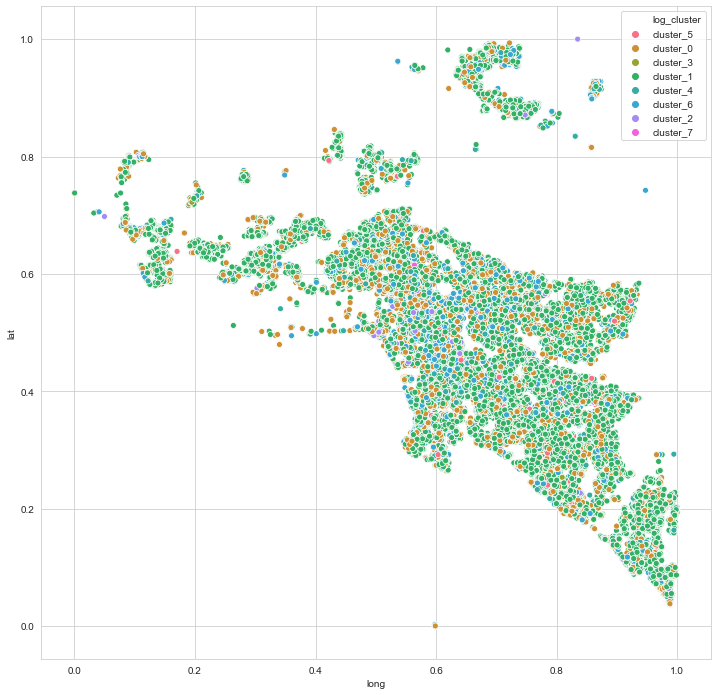

In [25]:
plt.figure(figsize = (12,12))
sns.scatterplot(x='long', y='lat', data=train, hue='log_cluster')

Text(0.5, 0.98, 'How is logerror distrubuted amoung property location? (latitude & longitude)')

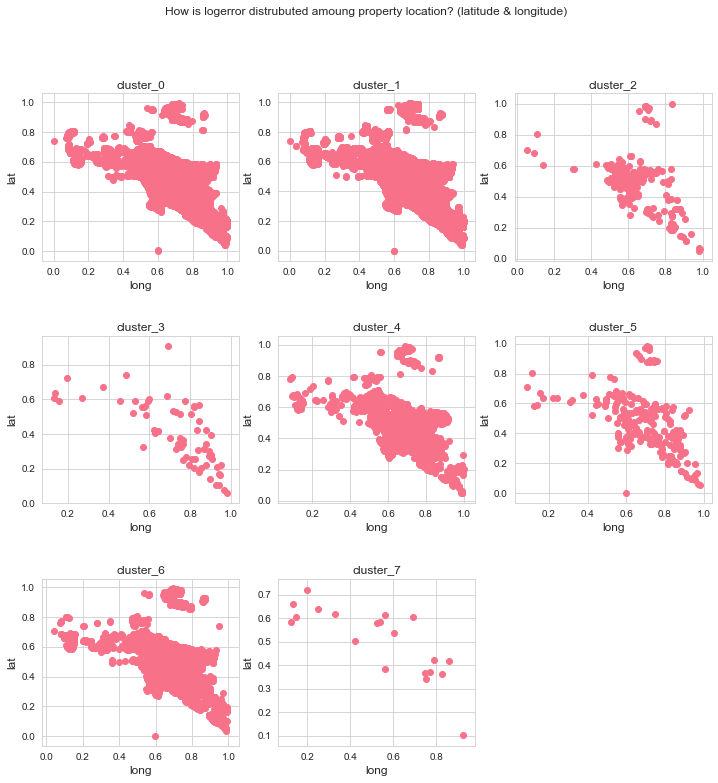

In [26]:
plt.figure(figsize = (12,12))
for i, cluster in enumerate(sorted(train.log_cluster.unique())):
    plt.subplot(3, 3, i + 1)
    subset = train[train.log_cluster == cluster]
    plt.scatter(subset.long, subset.lat, label=cluster)
    
    plt.title(f'{cluster}', size=12)
    plt.xlabel('long', size=12)
    plt.ylabel('lat', size=12)
    
#     plt.hlines(mpg.hwy.mean(), mpg.displ.min(), mpg.displ.max(), ls=':', color='red')
#     plt.vlines(mpg.displ.mean(), mpg.hwy.min(), mpg.hwy.max(), ls=':', color='red')

plt.subplots_adjust(hspace=.45)
plt.suptitle('How is logerror distrubuted amoung property location? (latitude & longitude)')

***Findings***
The logerror values spead accross all properties in the data set. There is no one area that has a specific set of logerrors to be idenditifed. From our t-test we found that all of our clusters were significant when compared to each other. Because all of these clusters were significant there are no clusters that we can combine together to make into subsets.

### Explore: Cluster on lat, long

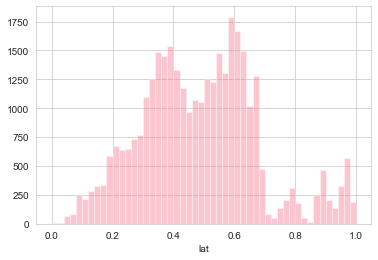

In [30]:
sns.distplot(train.lat, kde = False)

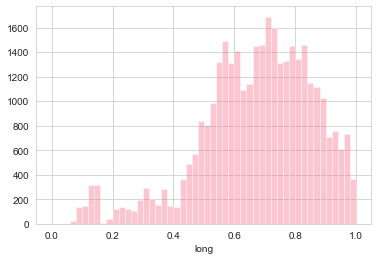

In [31]:
sns.distplot(train.long, kde = False)

     k          sse
0    1  2495.630073
1    2  1166.399023
2    3   845.333089
3    4   568.775071
4    5   415.850494
5    6   310.707640
6    7   243.397096
7    8   200.420103
8    9   178.383739
9   10   159.274889
10  11   141.234172
11  12   125.825149


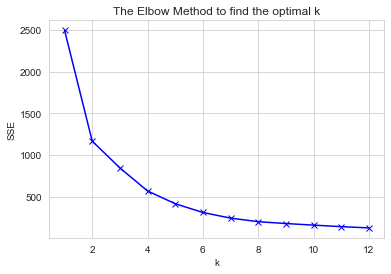

In [32]:
ks = range(1,13)
sse = []
for k in ks:
    kmeans = KMeans(n_clusters=k, random_state = 123)
    kmeans.fit(train[['lat', 'long']])

    # inertia: Sum of squared distanes of samplesto their closest cluster
    sse.append(kmeans.inertia_)
print(pd.DataFrame(dict(k=ks, sse=sse)))

plt.plot(ks, sse, 'bx-')
plt.xlabel('k')
plt.ylabel('SSE')
plt.title('The Elbow Method to find the optimal k')
plt.show()

In [33]:
pd.DataFrame(dict(k=ks, sse=sse)).assign(change_in_sse=lambda df: df.sse.diff())


k          sse  change_in_sse
0    1  2495.630073            NaN
1    2  1166.399023   -1329.231050
2    3   845.333089    -321.065934
3    4   568.775071    -276.558018
4    5   415.850494    -152.924576
5    6   310.707640    -105.142854
6    7   243.397096     -67.310544
7    8   200.420103     -42.976993
8    9   178.383739     -22.036364
9   10   159.274889     -19.108850
10  11   141.234172     -18.040718
11  12   125.825149     -15.409023

In [34]:
estimators = [('3 Clusters', KMeans(n_clusters=3)),
              ('7 Clusters', KMeans(n_clusters=7)),
             ('10 Clusters', KMeans(n_clusters=10))]

<Figure size 432x288 with 0 Axes>

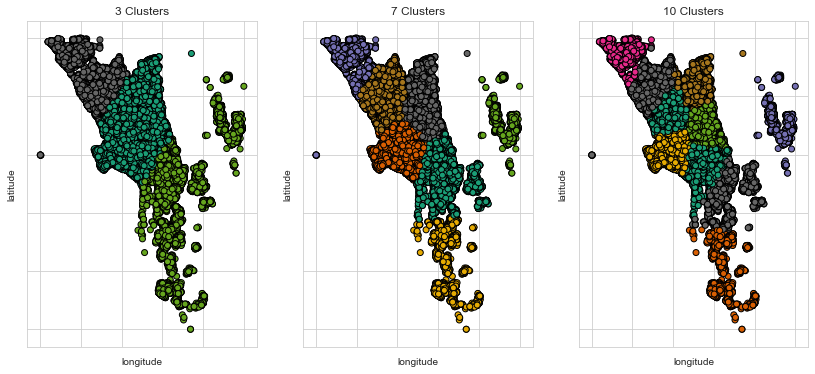

In [35]:
plt.set_cmap('Dark2')
fig, axs = plt.subplots(1, 3, figsize=(14, 6))

for ax, (title, kmeans) in zip(axs, estimators):
    # fit the kmeans object
    kmeans.fit(train[['lat','long']])

    labels = kmeans.labels_

    ax.scatter(train.lat, 
               train.long,
               c=labels.astype(np.float), edgecolor='k')
    ax.set(xticklabels=[], yticklabels=[])
    ax.set(xlabel='longitude', ylabel='latitude')
    ax.set(title=title)
    
    
    

In [36]:
kmeans_7 = KMeans(n_clusters = 7)
kmeans_7.fit(train[['lat','long']])

train['lat_long_cluster'] = kmeans_7.predict(train[['lat', 'long']])
train.lat_long_cluster = 'cluster_' + train.lat_long_cluster.astype('str')
train.lat_long_cluster.value_counts()

cluster_5    7318
cluster_3    6737
cluster_1    6273
cluster_2    5478
cluster_6    3626
cluster_4    2618
cluster_0    2165
Name: lat_long_cluster, dtype: int64

In [37]:
kmeans_8 = KMeans(n_clusters = 8)
kmeans_8.fit(train[['lat','long']])

train['lat_long_cluster_8'] = kmeans_8.predict(train[['lat', 'long']])
train.lat_long_cluster_8 = 'cluster_' + train.lat_long_cluster_8.astype('str')
train.lat_long_cluster_8.value_counts()

cluster_5    6296
cluster_0    5731
cluster_6    5648
cluster_7    4736
cluster_2    4449
cluster_1    3008
cluster_4    2182
cluster_3    2165
Name: lat_long_cluster_8, dtype: int64

In [39]:
pd.DataFrame(kmeans_7.cluster_centers_, columns=train[['lat', 'long']].columns)\
    .reset_index()\
    .rename({'index': 'cluster'}, axis=1)\
    .set_index('cluster')

lat      long
cluster                    
0        0.930400  0.702662
1        0.416166  0.615855
2        0.530581  0.775068
3        0.630646  0.523955
4        0.648357  0.237941
5        0.339018  0.799111
6        0.178470  0.925176

In [40]:
pd.DataFrame(kmeans_8.cluster_centers_, columns=train[['lat', 'long']].columns)\
    .reset_index()\
    .rename({'index': 'cluster'}, axis=1)\
    .set_index('cluster')

lat      long
cluster                    
0        0.551588  0.601249
1        0.166147  0.939176
2        0.660587  0.475080
3        0.930400  0.702662
4        0.648245  0.212260
5        0.318927  0.819745
6        0.380558  0.647426
7        0.510666  0.802470

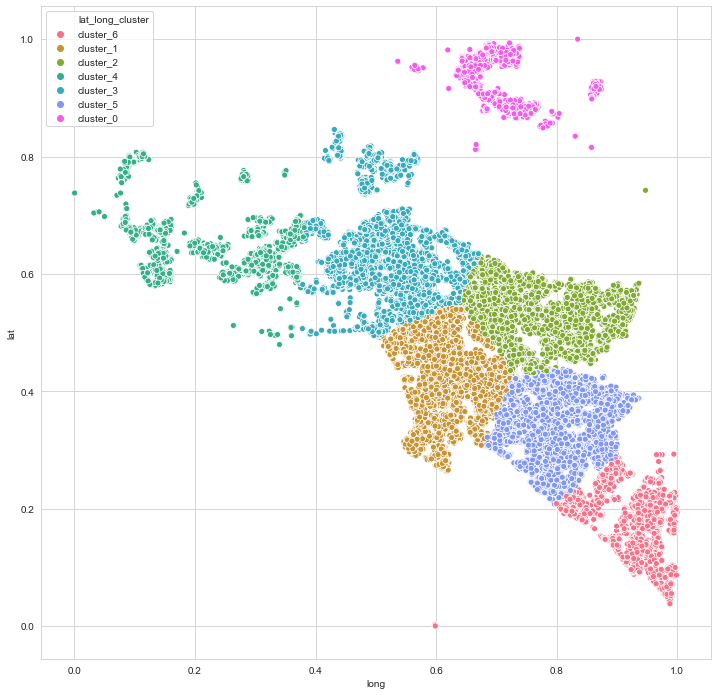

In [41]:
plt.figure(figsize = (12,12))
sns.scatterplot(x='long', y='lat', data=train, hue='lat_long_cluster')

In [42]:
logerrors = []
age = []
clusters = []
for i in sorted(train.lat_long_cluster.unique()):
    logerrors = logerrors + [train[train.lat_long_cluster == i].logerror.mean()]
    age = age + [train[train.lat_long_cluster == i].age.mean()]
    clusters.append(i)

lat_long_logerror = pd.DataFrame({'clusters': clusters, 'logerror': logerrors, 'age': age})
lat_long_logerror

clusters  logerror       age
0  cluster_0  0.012258  0.217622
1  cluster_1  0.009292  0.509727
2  cluster_2  0.023443  0.448226
3  cluster_3  0.014847  0.418257
4  cluster_4  0.013608  0.291084
5  cluster_5  0.021648  0.368508
6  cluster_6  0.028182  0.238853

In [43]:
logerrors = []
age = []
clusters = []
for i in sorted(train.lat_long_cluster_8.unique()):
    logerrors = logerrors + [train[train.lat_long_cluster_8 == i].logerror.mean()]
    age = age + [train[train.lat_long_cluster_8 == i].age.mean()]
    clusters.append(i)

lat_long_cluster_8 = pd.DataFrame({'clusters': clusters, 'logerror': logerrors, 'age': age})
lat_long_cluster_8

clusters  logerror       age
0  cluster_0  0.001974  0.532158
1  cluster_1  0.026027  0.230918
2  cluster_2  0.020330  0.361252
3  cluster_3  0.012258  0.217622
4  cluster_4  0.012503  0.294458
5  cluster_5  0.024634  0.341614
6  cluster_6  0.015893  0.476516
7  cluster_7  0.027613  0.413701

In [44]:
avg_age = list(train[['lat_long_cluster','age']].groupby('lat_long_cluster').mean().sort_values(by='age').index)
avg_age

['cluster_0',
 'cluster_6',
 'cluster_4',
 'cluster_5',
 'cluster_3',
 'cluster_2',
 'cluster_1']

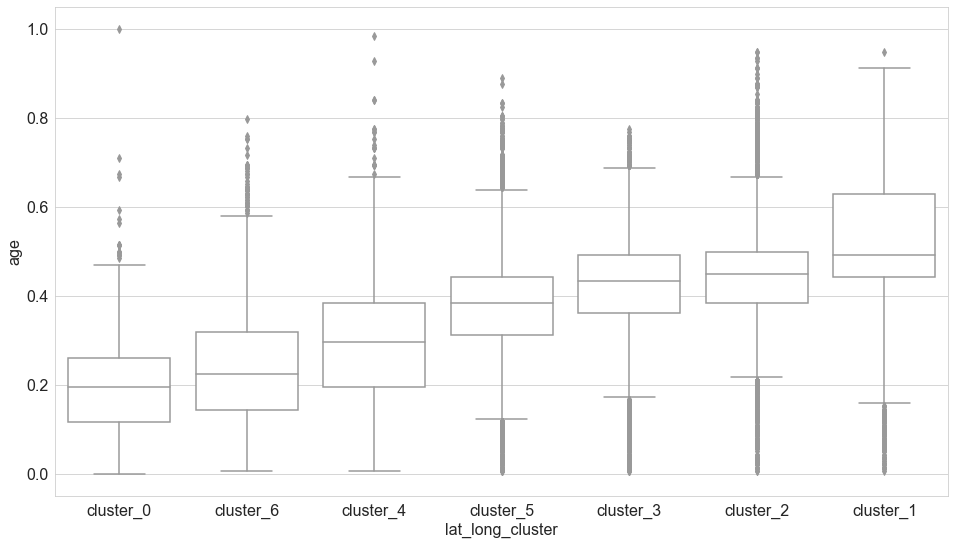

In [72]:
plt.rc('font', size=16)
plt.figure(figsize = (16,9))
sns.boxplot(x = 'lat_long_cluster', y = 'age', data=train, order = avg_age, color = 'white')
                                                                   

In [46]:
kmeans.cluster_centers_

array([[0.55612751, 0.56140901],
       [0.38361001, 0.7433373 ],
       [0.64818693, 0.21153911],
       [0.93040035, 0.70266192],
       [0.16105401, 0.94735463],
       [0.56316417, 0.69241381],
       [0.39191705, 0.6087694 ],
       [0.51668833, 0.84373436],
       [0.66686699, 0.46952057],
       [0.29664395, 0.83642035]])

In [47]:
centers = pd.DataFrame(kmeans_7.cluster_centers_, 
             train.groupby('lat_long_cluster').age.mean(), 
             columns = ['lat', 'long']).reset_index()
                                                                                             
centers

age       lat      long
0  0.217622  0.930400  0.702662
1  0.509727  0.416166  0.615855
2  0.448226  0.530581  0.775068
3  0.418257  0.630646  0.523955
4  0.291084  0.648357  0.237941
5  0.368508  0.339018  0.799111
6  0.238853  0.178470  0.925176

In [48]:
list(centers.index)

[0, 1, 2, 3, 4, 5, 6]

In [49]:
centers = pd.DataFrame({'lat_centers': kmeans_7.cluster_centers_[:,0],
                'long_centers': kmeans_7.cluster_centers_[:,1],
            'age_mean': train.groupby('lat_long_cluster').age.mean(),
             'logerror': train.groupby('lat_long_cluster').logerror.mean(),
             'tax': train.groupby('lat_long_cluster').tax.mean(),
             'sqft': train.groupby('lat_long_cluster').sqft.mean(),
             'lotsqft': train.groupby('lat_long_cluster').lotsqft.mean()}).reset_index()
centers

lat_long_cluster  lat_centers  long_centers  age_mean  logerror       tax  \
0        cluster_0     0.930400      0.702662  0.217622  0.012258  0.890776   
1        cluster_1     0.416166      0.615855  0.509727  0.009292  0.591729   
2        cluster_2     0.530581      0.775068  0.448226  0.023443  0.602820   
3        cluster_3     0.630646      0.523955  0.418257  0.014847  0.508358   
4        cluster_4     0.648357      0.237941  0.291084  0.013608  0.251161   
5        cluster_5     0.339018      0.799111  0.368508  0.021648  0.447726   
6        cluster_6     0.178470      0.925176  0.238853  0.028182  0.222272   

       sqft   lotsqft  
0  0.530582  0.625530  
1  0.382985  0.361501  
2  0.430662  0.585943  
3  0.534849  0.619106  
4  0.577641  0.575121  
5  0.495085  0.441401  
6  0.677938  0.377550

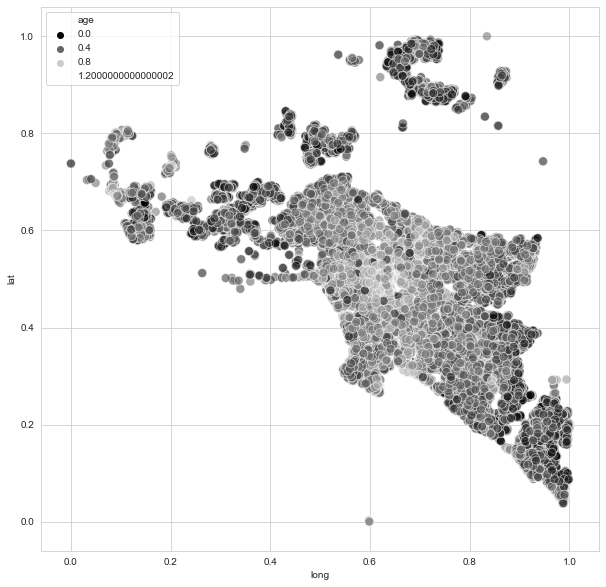

In [50]:
plt.figure(figsize=(10,10))
sns.scatterplot(x='long', y='lat', data=train, hue='age', s=80, alpha = .6, palette = 'gray')

<Figure size 432x288 with 0 Axes>

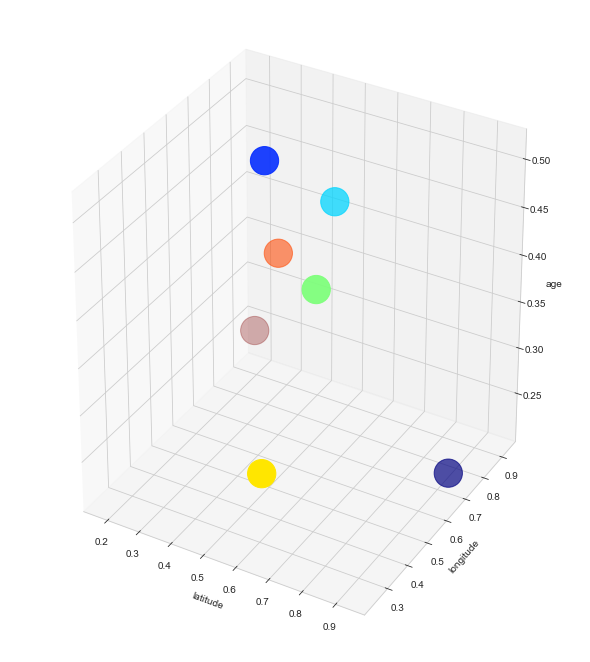

In [51]:
%matplotlib widget
%matplotlib notebook
%matplotlib inline

plt.set_cmap('jet')
fig = plt.figure(figsize=(8, 9))
ax = Axes3D(fig)



ax.scatter(centers.lat_centers, centers.long_centers, centers.age_mean, c= list(centers.index), s=800)
ax.set(xlabel='latitude', ylabel='longitude', zlabel='age')
plt.show()
#ax.scatter(train.long, train.lat, train.age, c=kmeans.labels_)


In [52]:
significant_clusters = []
p_vals = []

for i in train.lat_long_cluster.unique():
    stat, pval = stats.ttest_ind(
        train[train.lat_long_cluster == i].age,
        train[train.lat_long_cluster != i].age)
    if pval < .05:
        significant_clusters = significant_clusters + [i]
        p_vals = p_vals + [pval]
pd.DataFrame({'significant_clusters': significant_clusters, 'p_vals': p_vals}).set_index('significant_clusters')

p_vals
significant_clusters               
cluster_6              0.000000e+00
cluster_1              0.000000e+00
cluster_2             3.537740e-197
cluster_4             5.291591e-219
cluster_3              2.758449e-65
cluster_5              1.037478e-29
cluster_0              0.000000e+00

In [53]:
centers = pd.DataFrame({'lat_centers': kmeans_8.cluster_centers_[:,0],
                'long_centers': kmeans_8.cluster_centers_[:,1],
            'age_mean': train.groupby('lat_long_cluster_8').age.mean(),
             'logerror': train.groupby('lat_long_cluster_8').logerror.mean(),
             'tax': train.groupby('lat_long_cluster_8').tax.mean(),
             'sqft': train.groupby('lat_long_cluster_8').sqft.mean(),
             'lotsqft': train.groupby('lat_long_cluster_8').lotsqft.mean()}).reset_index()
centers

lat_long_cluster_8  lat_centers  long_centers  age_mean  logerror       tax  \
0          cluster_0     0.551588      0.601249  0.532158  0.001974  0.464915   
1          cluster_1     0.166147      0.939176  0.230918  0.026027  0.216016   
2          cluster_2     0.660587      0.475080  0.361252  0.020330  0.563714   
3          cluster_3     0.930400      0.702662  0.217622  0.012258  0.890776   
4          cluster_4     0.648245      0.212260  0.294458  0.012503  0.223104   
5          cluster_5     0.318927      0.819745  0.341614  0.024634  0.404031   
6          cluster_6     0.380558      0.647426  0.476516  0.015893  0.601867   
7          cluster_7     0.510666      0.802470  0.413701  0.027613  0.617997   

       sqft   lotsqft  
0  0.482165  0.505110  
1  0.685671  0.392933  
2  0.539201  0.641059  
3  0.530582  0.625530  
4  0.569735  0.563846  
5  0.538031  0.453650  
6  0.358088  0.341704  
7  0.439322  0.592908

In [54]:
significant_clusters = []
p_vals = []

for i in train.lat_long_cluster.unique():
    stat, pval = stats.ttest_ind(
        train[train.lat_long_cluster_8 == i].age,
        train[train.lat_long_cluster_8 != i].age)
    if pval < .05:
        significant_clusters = significant_clusters + [i]
        p_vals = p_vals + [pval]
pd.DataFrame({'significant_clusters': significant_clusters, 'p_vals': p_vals}).set_index('significant_clusters')

p_vals
significant_clusters               
cluster_6              0.000000e+00
cluster_1              0.000000e+00
cluster_2              6.911799e-31
cluster_4             1.299619e-167
cluster_3              0.000000e+00
cluster_5             8.569989e-136
cluster_0              0.000000e+00

### Cluster lat, long, tax_rate

In [55]:
[x for x in range(0, 5)]


[0, 1, 2, 3, 4]

Text(0.5, 0, 'tax rate')

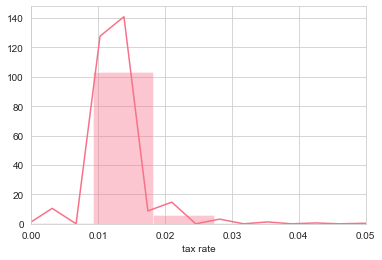

In [60]:
sns.distplot(zillow.tax)
plt.xlim(0,0.05)
#plt.xticks([x * 0.01 for x in range(0, 5)])
plt.xlabel('tax rate')

     k          sse
0    1  5347.068156
1    2  3117.040712
2    3  2163.168459
3    4  1596.929792
4    5  1278.511098
5    6  1065.711403
6    7   919.654398
7    8   803.499811
8    9   721.308815
9   10   646.640243
10  11   599.328667
11  12   557.442179


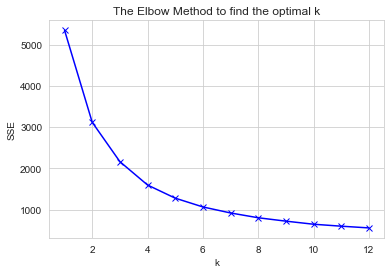

In [62]:
ks = range(1,13)
sse = []
for k in ks:
    kmeans = KMeans(n_clusters=k, random_state = 123)
    kmeans.fit(train[['lat', 'long', 'tax']])

    # inertia: Sum of squared distanes of samplesto their closest cluster
    sse.append(kmeans.inertia_)
print(pd.DataFrame(dict(k=ks, sse=sse)))

plt.plot(ks, sse, 'bx-')
plt.xlabel('k')
plt.ylabel('SSE')
plt.title('The Elbow Method to find the optimal k')
plt.show()

In [63]:
pd.DataFrame(dict(k=ks, sse=sse)).assign(change_in_sse=lambda df: df.sse.diff())


k          sse  change_in_sse
0    1  5347.068156            NaN
1    2  3117.040712   -2230.027444
2    3  2163.168459    -953.872254
3    4  1596.929792    -566.238667
4    5  1278.511098    -318.418694
5    6  1065.711403    -212.799695
6    7   919.654398    -146.057005
7    8   803.499811    -116.154587
8    9   721.308815     -82.190996
9   10   646.640243     -74.668572
10  11   599.328667     -47.311576
11  12   557.442179     -41.886487

In [64]:
estimators = [('3 Clusters', KMeans(n_clusters=3)),
              ('9 Clusters', KMeans(n_clusters=7))]

<Figure size 432x288 with 0 Axes>

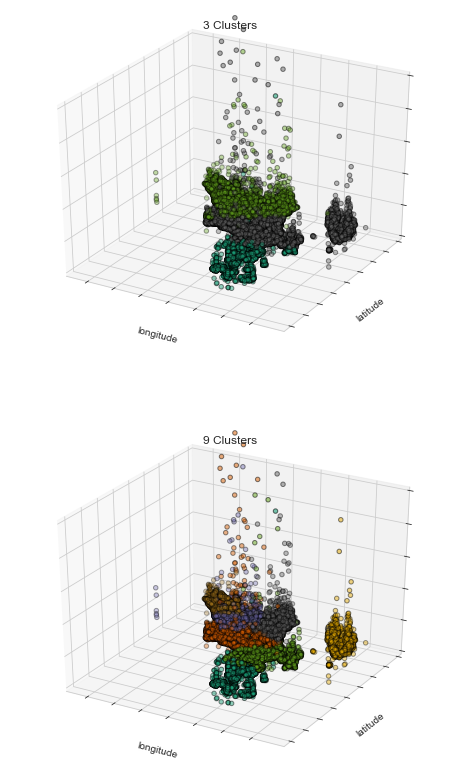

In [67]:
%matplotlib widget
%matplotlib inline
plt.set_cmap('Dark2')
fig, axs = plt.subplots(2, 1, figsize=(8, 14), subplot_kw={'projection': '3d'})

for ax, (title, kmeans) in zip(axs, estimators):
    # fit the kmeans object
    kmeans.fit(zillow[['lat','long','tax']])

    labels = kmeans.labels_

    ax.scatter(zillow.lat, 
               zillow.long,
               zillow.tax,
               c=labels.astype(np.float), edgecolor='k')
    ax.set(xticklabels=[], yticklabels=[], zticklabels=[])
    ax.set(xlabel='longitude', ylabel='latitude')
    ax.set(zlim = (0,.1))
    ax.set(title=title)
